In [0]:
import pandas as pd
import numpy as np
from astropy import constants as cte
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline


url = 'https://raw.githubusercontent.com/seba1224/frbs/master/frbs.csv'
df = pd.read_csv(url,delimiter=',')
data = df.values
frb_name = data[:,0]
frb_bw = data[:,4]              #MHz
frb_center = data[:,5]     #MHz
frb_s = data[:,6]               #in Jansky
frb_flux = data[:,7]            #in Jy ms
frb_width = data[:,8]           #in ms
frb_DM = data[:,9]              #cm**-3*pc


for i in range(len(frb_DM)):
    ind = np.char.find(frb_DM[i], '\xc2')
    frb_DM[i] = float(frb_DM[i][:ind])

frb_SNR = data[:,10]
frb_Tsys = data[:,11]

frb_init_frec = frb_center-frb_bw/2.
frb_end_frec = frb_center+frb_bw/2.


In [39]:
#frb 170827
frb_index = 31
DM = frb_DM[frb_index]
f1 = frb_init_frec[frb_index]
f2 = frb_end_frec[frb_index]
T = 100*u.K
S = frb_s[frb_index]*u.Jy
Aeff = 18*10**3*(u.m)**2
SN = frb_SNR[frb_index]
nu = 0.4

t = 4.15*10**6*(f1**(-2)-f2**(-2))*DM 
print(str(t)+' [ms]  \t'+'DM equation'+'\t consistent with the image')

tau = (2*cte.k_B*T*SN/(S*Aeff))**2*1./(nu*10**6*u.Hz)
print(str(tau.to(u.ms))+'  \t'+'radiometer eq')

80.5352856255 [ms]  	DM equation	 consistent with the image
1.88352028562 ms  	radiometer eq


![alt text](https://raw.githubusercontent.com/seba1224/frbs/master/frb170827.png)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


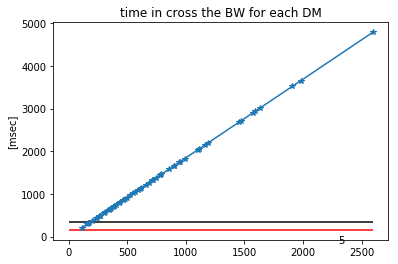

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


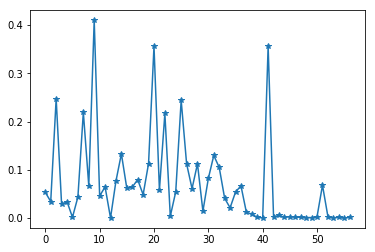

In [11]:
### HIPERPARAMETERS
f1 = 1200. #MHz   #con el sergio teniamos 540MHz
f2 = 2000. #MHz
channels = 64.
d = 30.*u.m
Tsys = 200*u.K
ef = 1#0.8
Ae= (d/2)**2*np.pi*ef
delta_f = np.linspace(f1,f2,channels, endpoint=False)
delta_f = delta_f[1]-delta_f[0]

bw = (f2-f1)*10**6
fpga_clk = bw/8
bram_cycles = 2. #how many cycles are saved in one addr of the dram
dram_time = 2**24*bram_cycles/(fpga_clk)

frb_DM2 = np.sort(frb_DM)
tau = frb_DM2*(f1**(-2)-f2**(-2))*4.15*10**6

aux = np.where(tau<dram_time*1000)



t_DM = 8.3*10**6*frb_DM2*delta_f*(f1**(-3))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(frb_DM2,tau, '*-')
ax.set_title('time in cross the BW for each DM')
ax.set_ylabel('[msec]')
ax.hlines(dram_time*1000,0,np.max(frb_DM2))
ax.hlines(np.max(t_DM),0, np.max(frb_DM2), color='r')
ax.text(np.max(frb_DM)-300,dram_time*1000-500,str(len(aux[0])))
plt.show()


def time_plots(f1,f2,chann):
    bw = (f2-f1)*10**6
    fpga_clk = bw/8
    bram_cycles = 2. #how many cycles are saved in one addr of the dram
    dram_time = 2**24*bram_cycles/(fpga_clk)
    delta_f = np.linspace(f1,f2,channels, endpoint=False)
    delta_f = delta_f[1]-delta_f[0]
    frb_DM2 = np.sort(frb_DM)
    t_DM = 8.3*10**6*frb_DM2*delta_f*(f1**(-3))
    tau = frb_DM2*(f1**(-2)-f2**(-2))*4.15*10**6
    aux = np.where(tau<dram_time*1000)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(frb_DM2,tau, '*-')
    ax.set_title('time in cross the BW for each DM')
    ax.set_ylabel('[msec]')
    ax.hlines(dram_time*1000,0,np.max(frb_DM2))
    ax.hlines(np.max(t_DM),0, np.max(frb_DM2), color='r')
    ax.text(np.max(frb_DM)-300,dram_time*1000-500,str(len(aux[0])))
    plt.show()





def SNR_cal(f1,f2,chann):
    bw = (f2-f1)*10**6
    fpga_clk = bw/8
    bram_cycles = 2.25 #how many cycles are saved in one addr of the dram
    dram_time = 2**24*bram_cycles/(fpga_clk)
    delta_f = np.linspace(f1,f2,channels, endpoint=False)
    delta_f = (delta_f[1]-delta_f[0])*u.Hz
    t_DM = 8.3*10**6*frb_DM*delta_f*(f1**(-3))
    tau = frb_DM*(f1**(-2)-f2**(-2))*4.15*10**6*u.ms
    aux = np.where(tau.value>dram_time*1000)
    SNR = frb_s*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(tau*delta_f)
    SNR = SNR.decompose()
    #ipdb.set_trace()
    SNR2 = np.copy(SNR)
    if np.size(aux)==0:
        pass
    else:
        SNR2[aux] = (frb_s[aux]*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(dram_time*delta_f)).decompose()
    return [SNR,aux, SNR2]



SNR,aux,SNR2 =SNR_cal(f1,f2, channels)

ind_nan = np.isnan(SNR2)
plt.figure()
plt.plot(SNR2[np.logical_not(ind_nan)], '*-')
plt.show()


In [0]:
def images(f1,f2,chann,d_,Tsys_):
  bw = (f2-f1)*10.**6*u.Hz
  d = d_*u.m
  Tsys = Tsys_*u.K
  ef = 1#0.8
  Ae= (d/2)**2*np.pi*ef
  delta_f = np.linspace(f1,f2,channels, endpoint=False)
  delta_f = delta_f[1]-delta_f[0]
  bw = (f2-f1)*10**6
  fpga_clk = bw/8
  bram_cycles = 2. #how many cycles are saved in one addr of the dram
  dram_time = 2**24*bram_cycles/(fpga_clk)
  
  #frb time
  frb_DM2 = np.sort(frb_DM)
  tau = frb_DM2*(f1**(-2)-f2**(-2))*4.15*10**6
  aux = np.where(tau<dram_time*1000)
  t_DM = 8.3*10**6*frb_DM2*delta_f*(f1**(-3))
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(frb_DM2,tau, '*-')
  ax.set_title('time  cross the BW for each DM')
  ax.set_ylabel('[msec]')
  ax.set_xlabel('DM')
  ax.hlines(dram_time*1000,0,np.max(frb_DM2))
  ax.hlines(np.max(t_DM),0, np.max(frb_DM2), color='r')
  ax.text(np.max(frb_DM)-300,dram_time*1000-500,str(len(aux[0])))

  tau = frb_DM*(f1**(-2)-f2**(-2))*4.15*10**6*u.ms
  aux = np.where(tau.value>dram_time*1000)
  SNR = frb_s*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(tau*bw)
  SNR = SNR.decompose()
  SNR2 = np.copy(SNR)
  if np.size(aux)==0:
      pass
  else:
      SNR2[aux] = (frb_s[aux]*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(dram_time*bw)).decompose()
  plt.figure()
  plt.title('SNR')
  plt.plot(SNR2[np.logical_not(ind_nan)], '*-')
  plt.ylabel('SNR lineal')
  plt.show()



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


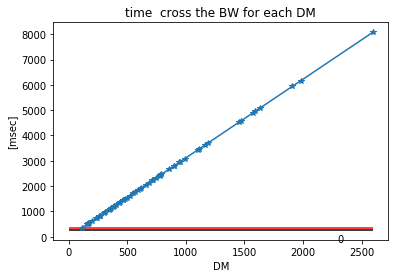

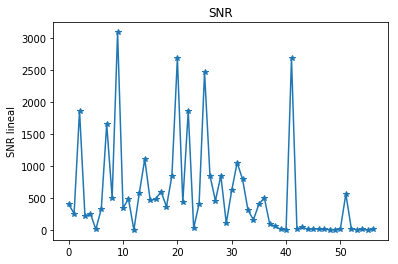

In [34]:
images(1000,2000,64,30,200)

In [0]:
def franco_style(f1,f2,chann,d_,Tsys_):
  bw = (f2-f1)*10.**6*u.Hz
  d = d_*u.m
  Tsys = Tsys_*u.K
  ef = 1#0.8
  Ae= (d/2)**2*np.pi*ef
  delta_f = np.linspace(f1,f2,channels, endpoint=False)
  delta_f = delta_f[1]-delta_f[0]
  bw = (f2-f1)*10**6
  fpga_clk = bw/8
  bram_cycles = 2. #how many cycles are saved in one addr of the dram
  dram_time = 2**24*bram_cycles/(fpga_clk)
  
  #frb time
  frb_DM2 = np.sort(frb_DM)
  tau = frb_width
  aux = np.where(tau<dram_time*1000)
  t_DM = 8.3*10**6*frb_DM2*delta_f*(f1**(-3))

  tau = frb_width*u.ms
  aux = np.where(tau.value>dram_time*1000)
  SNR = frb_s*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(tau*bw)
  SNR = SNR.decompose()
  SNR2 = np.copy(SNR)
  if np.size(aux)==0:
      pass
  else:
      SNR2[aux] = (frb_s[aux]*u.Jy*Ae/(2*cte.k_B*Tsys)*np.sqrt(dram_time*bw)).decompose()
  plt.figure()
  plt.title('SNR')
  plt.plot(SNR2[np.logical_not(ind_nan)], '*-')
  plt.ylabel('SNR lineal')
  plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


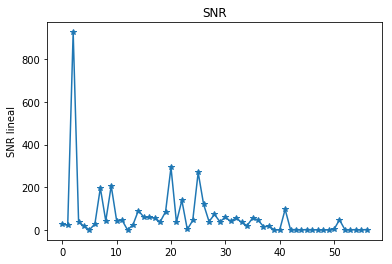

In [53]:
franco_style(1000,2000,64,30,200)